<a href="https://colab.research.google.com/github/meoowqt/pythonDataLab/blob/main/LW8_text_classification_Vechkanova_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Лабораторная работа #8: Классификация текстов

In [ ]:
!pip install stop_words

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
import sklearn
from stop_words import get_stop_words

In [ ]:
# В случае выпадения множественных warning'ов,
# затрудняющих чтение лабораторной, раскомментируйте и выполните код ниже:

import warnings
warnings.filterwarnings('ignore')

###Задание 1
1.1 Загрузить в pandas датасет для классификации текстов, категориальные признаки которого **не пересекаются** и число категорий относительно небольшое (не более 10, в случае чего можно самостоятельно урезать число категорий)

In [ ]:
df = pd.read_csv("imdb-spider-man-reviews.csv")
df = df.dropna()
df = df.drop(df[df['Movie']=='Spider-Man: No Way Home'].index)
df = df.drop(df[df['Movie']=='Spider-Man 3'].index)
df = df.drop(df[df['Movie']=='Spider-Man: Far from Home'].index)

df.head()

,Rating,Title,Date,Helpful_Vote,Total_Vote,Review,Movie
0,10.0,Fantastic...but possibly overwhelming.,26 March 2019,54,71,"""Spider-Man: Into the Spider-Verse"" is a fanta...",Spider-Man: Into the Spider-Verse
1,8.0,How on God's green Earth did this work so well???,21 December 2018,198,279,The worlds of superhero movies and superhero c...,Spider-Man: Into the Spider-Verse
2,10.0,Stan Lee Is Smiling Right Now,17 December 2018,773,947,A movie worthy of Stan Lee's approval. Incredi...,Spider-Man: Into the Spider-Verse
3,10.0,So Much More Than I Expected!,19 November 2019,38,50,"So many have commented, so I will be brief. Fr...",Spider-Man: Into the Spider-Verse
4,10.0,Game Changer,21 December 2018,373,517,Have you ever sat through a film and you knew ...,Spider-Man: Into the Spider-Verse


1.2 Удалите из датасета все элементы, которые являются малоинформативными (например, ссылки, любые цифры, хеши, стандартизированные заглавные и подвальные подписи, если датасет связан с письмами), т.е. всё, что не несет значимой информативной нагрузки в контексте естественного языка

In [ ]:
def remove_non_informative_elements(text):
    text = ' '.join([word for word in text.split() if not word.startswith('http')])
    text = ''.join([i for i in text if not i.isdigit()])
    text = ' '.join([word for word in text.split() if not word.startswith('#')])
    words = text.split()
    text = ' '.join([word for word in words if not (word.isupper() and len(word) > 1)])
    text = text.replace('"', '')
    text = text.replace("'", '')
    return text

df['Review'] = df['Review'].apply(remove_non_informative_elements)
df['Title'] = df['Title'].apply(remove_non_informative_elements)
df['Movie'] = df['Movie'].apply(remove_non_informative_elements)
df.head()

,Rating,Title,Date,Helpful_Vote,Total_Vote,Review,Movie
0,10.0,Fantastic...but possibly overwhelming.,26 March 2019,54,71,Spider-Man: Into the Spider-Verse is a fantast...,Spider-Man: Into the Spider-Verse
1,8.0,How on Gods green Earth did this work so well???,21 December 2018,198,279,The worlds of superhero movies and superhero c...,Spider-Man: Into the Spider-Verse
2,10.0,Stan Lee Is Smiling Right Now,17 December 2018,773,947,A movie worthy of Stan Lees approval. Incredib...,Spider-Man: Into the Spider-Verse
3,10.0,So Much More Than I Expected!,19 November 2019,38,50,"So many have commented, so I will be brief. Fr...",Spider-Man: Into the Spider-Verse
4,10.0,Game Changer,21 December 2018,373,517,Have you ever sat through a film and you knew ...,Spider-Man: Into the Spider-Verse


1.3 Применить стеммер из [nltk](https://www.nltk.org/howto/stem.html) ко всем  словам в датасете

In [ ]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
ps = PorterStemmer()

def stem_words(text):
    words = word_tokenize(text)
    stemmed_words = [ps.stem(word) for word in words]
    stemmed_text = ' '.join(stemmed_words)
    return stemmed_text

df['Review'] = df['Review'].apply(stem_words)
df['Title'] = df['Title'].apply(stem_words)
df['Movie'] = df['Movie'].apply(stem_words)

df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Rating,Title,Date,Helpful_Vote,Total_Vote,Review,Movie
0,10.0,fantast ... but possibl overwhelm .,26 March 2019,54,71,spider-man : into the spider-vers is a fantast...,spider-man : into the spider-vers
1,8.0,how on god green earth did thi work so well ? ? ?,21 December 2018,198,279,the world of superhero movi and superhero comi...,spider-man : into the spider-vers
2,10.0,stan lee is smile right now,17 December 2018,773,947,a movi worthi of stan lee approv . incred anim...,spider-man : into the spider-vers
3,10.0,so much more than i expect !,19 November 2019,38,50,"so mani have comment , so i will be brief . fr...",spider-man : into the spider-vers
4,10.0,game changer,21 December 2018,373,517,have you ever sat through a film and you knew ...,spider-man : into the spider-vers


1.4 Получить матрицу TfIdf c помощью `TfidfVectorizer`. Можете использовать его как с параметрами из ячейки ниже, так и подобрать свои

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

en_stopwords = get_stop_words('en')

tfidf_vectorizer = TfidfVectorizer(
    max_df = 0.1,
    max_features = 5000,
    min_df = 0.008,
    stop_words = en_stopwords,
    use_idf = True,
    token_pattern = '[a-zA-Z_]{2,}',
    ngram_range = (1,3),
    lowercase = False
)

tfidf_matrix = tfidf_vectorizer.fit_transform(df['Review'])
print(tfidf_matrix)

  (0, 1885)	0.12064231104207024
  (0, 1072)	0.12376102556974178
  (0, 1987)	0.09494852198885351
  (0, 2191)	0.11428230718098345
  (0, 1286)	0.11904018592758829
  (0, 2000)	0.1072363174242571
  (0, 185)	0.1052520207747981
  (0, 1180)	0.09176193705999526
  (0, 1851)	0.14079702791214382
  (0, 965)	0.12194994686375853
  (0, 193)	0.13401731251582072
  (0, 1884)	0.1183345559477208
  (0, 1893)	0.12361687409436709
  (0, 624)	0.10636621749587286
  (0, 1071)	0.11904018592758829
  (0, 1267)	0.09454887487287368
  (0, 2190)	0.11275761647364783
  (0, 1383)	0.12128743354049155
  (0, 2113)	0.084031772514794
  (0, 2013)	0.1048468837537058
  (0, 1284)	0.10594245258267189
  (0, 1858)	0.13232162254805477
  (0, 993)	0.10212378360754942
  (0, 1206)	0.10658087175196504
  (0, 1840)	0.12818431823809212
  :	:
  (9615, 979)	0.0691262181291982
  (9615, 1795)	0.07164978251125223
  (9615, 28)	0.08908455553686886
  (9615, 245)	0.08838087420789618
  (9615, 668)	0.07782651100754429
  (9615, 2080)	0.0887685794567855
  

###Задание 2

2.1 Обучить модель `LogisticRegression` с помощью кросс-валидации. В зависимости от количестве классов в датасете вывести метрику accuracy для многоклассового случая, либо составить `classification_report` для бинарной

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate

X = tfidf_matrix
y = df['Movie']

model = LogisticRegression(random_state = 2)

scores = cross_val_score(model, X, y, scoring='accuracy')

print(f"Accuracy: {np.mean(scores):}")

Accuracy: 0.848169764628423



2.2 Объедините TfidfVectorizer и LogisticRegression в один [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

In [ ]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('tfidf', tfidf_vectorizer), ('logistic', LogisticRegression(max_iter=500, random_state = 6))])

2.3 Составьте словарь для варьирования параметров пайплайна. В словаре должны варьироваться следующие параметры:


* `max_df`, `min_df` и `max_features` для `TfidfVectorizer` в диапазонах (0.1, 1), (0.001, 0.09) и (250, 1000) соответственно. Каждый диапазон должен включать 3-5 значений
* C для `LogisticRegression` в диапазоне (0.1, 1) Диапазон должен включать минимуи 4 значения



In [ ]:
params = {'tfidf__max_df':[0.1,  0.5, 1.0],
          'tfidf__min_df':[0.001, 0.05, 0.09],
          'tfidf__max_features':[250, 750, 1000],
          'logistic__C':[0.1, 0.4, 0.7, 1.0]}

2.4 Найти лучшие гиперпараметры из предыдушего пункта с помощью GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(pipeline, param_grid=params, scoring='accuracy', verbose=4, cv=6, error_score='raise')
grid_search.fit(df['Review'], df['Movie'])

[CV 4/6] END logistic__C=0.4, tfidf__max_df=1.0, tfidf__max_features=250, tfidf__min_df=0.09;, score=0.797 total time=  12.4s
[CV 5/6] END logistic__C=0.4, tfidf__max_df=1.0, tfidf__max_features=250, tfidf__min_df=0.09;, score=0.793 total time=  15.7s
[CV 6/6] END logistic__C=0.4, tfidf__max_df=1.0, tfidf__max_features=250, tfidf__min_df=0.09;, score=0.785 total time=  12.7s
[CV 1/6] END logistic__C=0.4, tfidf__max_df=1.0, tfidf__max_features=750, tfidf__min_df=0.001;, score=0.874 total time=  12.3s
[CV 2/6] END logistic__C=0.4, tfidf__max_df=1.0, tfidf__max_features=750, tfidf__min_df=0.001;, score=0.881 total time=  12.4s
[CV 3/6] END logistic__C=0.4, tfidf__max_df=1.0, tfidf__max_features=750, tfidf__min_df=0.001;, score=0.861 total time=  12.7s
[CV 4/6] END logistic__C=0.4, tfidf__max_df=1.0, tfidf__max_features=750, tfidf__min_df=0.001;, score=0.875 total time=  12.9s
[CV 5/6] END logistic__C=0.4, tfidf__max_df=1.0, tfidf__max_features=750, tfidf__min_df=0.001;, score=0.878 total 

GridSearchCV(cv=6, error_score='raise',
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(lowercase=False,
                                                        max_df=0.8,
                                                        max_features=5000,
                                                        min_df=0.002,
                                                        ngram_range=(1, 3),
                                                        stop_words=['a',
                                                                    'about',
                                                                    'above',
                                                                    'after',
                                                                    'again',
                                                                    'against',
                                                                    'all', 'am',
                                                                    'an', 'and',
                                                                    'any',
                                                                    'are',
                                                                    "aren't",
                                                                    'as', 'at',
                                                                    'be',
                                                                    'because',
                                                                    'been',
                                                                    'before',
                                                                    'being',
                                                                    'below',
                                                                    'between',
                                                                    'both',
                                                                    'but', 'by',
                                                                    "can't",
                                                                    'cannot',
                                                                    'could',
                                                                    "couldn't",
                                                                    'did', ...],
                                                        token_pattern='[a-zA-Z_]{2,}')),
                                       ('logistic',
                                        LogisticRegression(max_iter=500,
                                                           random_state=6))]),
             param_grid={'logistic__C': [0.1, 0.4, 0.7, 1.0],
                         'tfidf__max_df': [0.1, 0.5, 1.0],
                         'tfidf__max_features': [250, 750, 1000],
                         'tfidf__min_df': [0.001, 0.05, 0.09]},
             scoring='accuracy', verbose=4)

2.5 Вывести показатель accuracy/`classification_report` для лучшей модели

In [ ]:
print("Лучший score:", grid_search.best_score_)

Лучший score: 0.877496197438791


2.6 Вывести гиперпараметры лучшей модели

In [ ]:
print("Лучшие параметры:", grid_search.best_params_)

Лучшие параметры: {'logistic__C': 0.7, 'tfidf__max_df': 0.5, 'tfidf__max_features': 1000, 'tfidf__min_df': 0.001}


2.7 Построить confusion matrix для оценки того, какие ошибки классификатор допускает чаще всего

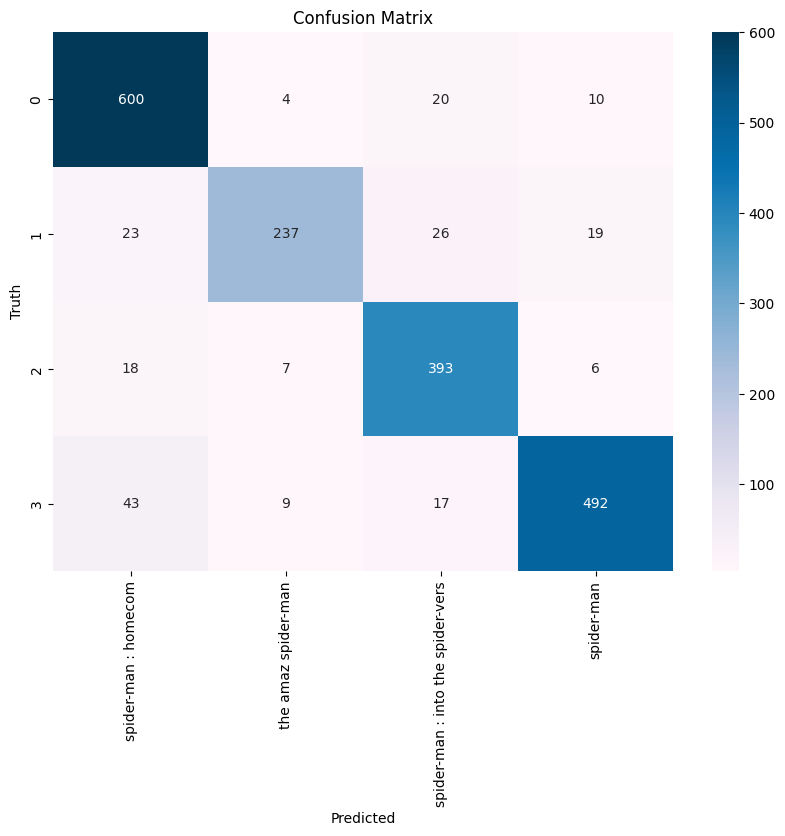

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(df['Review'], df['Movie'], test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
unique_categories = y_test.unique()

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='PuBu', xticklabels=unique_categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()